<img src="Electronic_Brain.png" width="200" style="float:left">
<h1> Summer 2021 ML Course.</h1>
<h2> Exercise 9: Noisy Features<br>Tools: Numpy, Pandas, Scikit-Learn</h2>

In [1]:
!python --version
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import gauss, randint

import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from icecream import ic

Python 3.8.3


In [2]:
# Set a few defaults.
np.random.seed(66)
pd.set_option('display.precision', 3)
plt.rcParams['figure.figsize'] = [15, 5]

<img src="desktop-computer-icon.png" width="40" style="float:left">
<h1> &nbsp; Section A: Signal Generation.</h1>

In [3]:
"""
Generate AAPL's "bipolar" behavior, alternating between price levels of 10 and 30 USD with noise, for 20 days at a time.
Our target function today is a "long straddle".
Basically, the long straddle makes money on big price swings (up *OR* down),
and loses when prices are "calm" (within a relatively flat range).
"""
def generate_prices(sigma=5, regime_len=20, num_regimes=20, num_noise_features=10):
    prices_df = pd.DataFrame()
    appl_prices = np.array([])
    for i in range(num_regimes):
        curr_prices = 20 + 10*(-1)**i + np.random.normal(0, sigma, regime_len)
        appl_prices = np.append(appl_prices, curr_prices)

    prices_df['AAPL'] = appl_prices
    series_len = len(prices_df['AAPL'])

    # Generate backward & forward 10-day gains (*NOT* rolling means).
    prices_df['AAPL_back_10_day_gain'] = prices_df['AAPL'] - prices_df['AAPL'].shift(10)
    prices_df['AAPL_back_30_day_gain'] = prices_df['AAPL'] - prices_df['AAPL'].shift(30)
    features = ['AAPL_back_10_day_gain', 'AAPL_back_30_day_gain']

    # Add noise features. These can and will hurt performance.
    for i in range(num_noise_features):
        prices_df['noise_' + str(i)] = np.random.normal(0, 20, series_len)
        features.append('noise_'+str(i))
    
    # Create the "long straddle" (continuous) target function.
    prices_df['target'] = abs(prices_df['AAPL'] - prices_df['AAPL'].shift(-10)) - 20

    # Return a "clean" version of the prices dataframe, with no missing values.
    prices_df.dropna(inplace=True)
    return(features, prices_df)

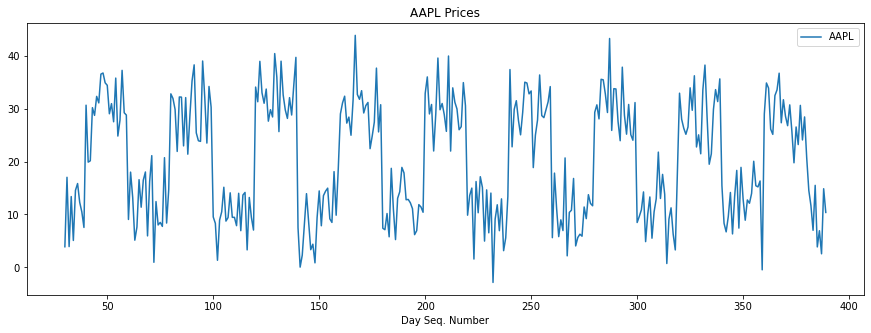

In [4]:
num_noise_features = 15
features, Apple_df = generate_prices(num_noise_features=num_noise_features)

# A little reminder of the original time series dataset.
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots()
ax.plot(Apple_df['AAPL'], label='AAPL')
ax.set(xlabel='Day Seq. Number', title='AAPL Prices');
plt.legend();

In [5]:
"""
Perform 25-fold cross validation to estimate the regressor's accuracy.
Check the scikit-learn documentation to check how score() scores the regression algorithms.
"""
def eval_regression(reg_func, features, target_field, X_df):
    losses = np.zeros(25)
    for i in range(25):
        X_train, X_test, y_train, y_test = train_test_split(X_df[features], X_df[target_field], test_size=0.1)
        reg_func.fit(X_train, y_train)
        
        # Evaluate the regression results on the held-out test set.
        # Option 1: evaluate the regression results using the regressors' built-in score() function (see previous exercise).
        # Option 2: evaluate the test-set loss using a user-defined loss function.
        # In this case, we use the mean absolute error (== L1 loss) per sample.
        losses[i] = np.linalg.norm(y_test - reg_func.predict(X_test), ord=1) / len(y_test)

    return([np.mean(losses), np.std(losses)])

<img src="desktop-computer-icon.png" width="40" style="float:left">
<h1> &nbsp; Section B: Regression Training and Visualization</h1>

In [6]:
poly_order = 2
num_neighbs = 25
curr_features = ['AAPL_back_10_day_gain', 'AAPL_back_30_day_gain']
loss_means = {
    'ols_poly' : [],
    'knn'      : [],
    'dec_tree' : [],
    'boosted_tree' : [],
}
loss_stds = {
    'ols_poly' : [],
    'knn'      : [],
    'dec_tree' : [],
    'boosted_tree' : [],
}

# Use the tqdm progress bar.
# It's no coincidence the word sounds familiar, the guy who wrote this library is Israeli!
for i in tqdm(range(num_noise_features + 1)):
    if i>0:
        curr_features.append('noise_' + str(i-1))
    X = Apple_df[curr_features]
    y = Apple_df['target']

    # Train a second order polynomial linear regressor on the continuous target.
    regressor = LinearRegression()
    ols_poly_model = make_pipeline(PolynomialFeatures(poly_order), regressor)
    ols_poly_model.fit(X,y)
    ols_poly_mean, ols_poly_std = eval_regression(ols_poly_model, curr_features, 'target', Apple_df)
    loss_means['ols_poly'].append(ols_poly_mean)
    loss_stds['ols_poly'].append(ols_poly_std)

    # Add a K-nearest-neighbor regressor.
    knn_reg = KNeighborsRegressor(n_neighbors=num_neighbs)
    knn_reg.fit(X, y)
    knn_mean, knn_std = eval_regression(knn_reg, curr_features, 'target', Apple_df)
    loss_means['knn'].append(knn_mean)
    loss_stds['knn'].append(knn_std)
    
    # A Decision tree.
    dec_tree_reg = DecisionTreeRegressor()
    dec_tree_reg.fit(X, y)
    dec_tree_mean, dec_tree_std = eval_regression(dec_tree_reg, curr_features, 'target', Apple_df)
    loss_means['dec_tree'].append(dec_tree_mean)
    loss_stds['dec_tree'].append(dec_tree_std)
    
    # And a boosted decision tree.
    boosted_tree_reg = AdaBoostRegressor(random_state=0, n_estimators=100)
    boosted_tree_reg.fit(X, y)
    btree_mean, btree_std = eval_regression(boosted_tree_reg, curr_features, 'target', Apple_df)
    loss_means['boosted_tree'].append(btree_mean)
    loss_stds['boosted_tree'].append(btree_std)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:51<00:00,  3.25s/it]


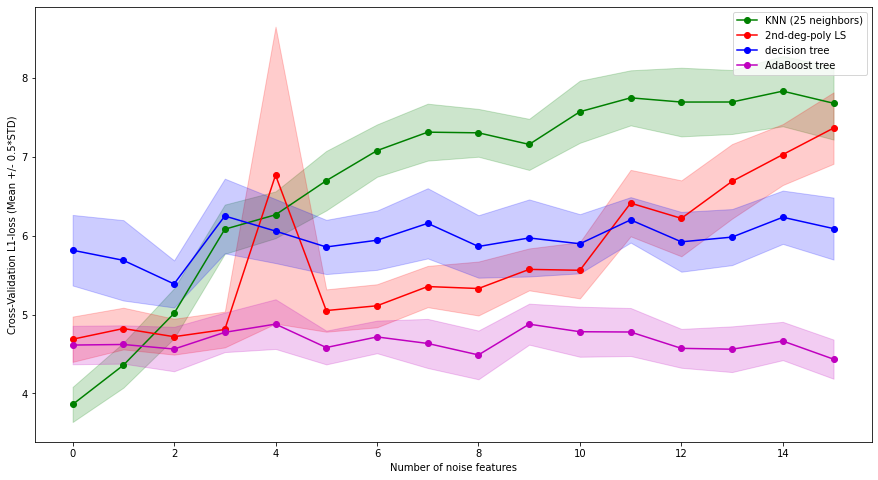

In [7]:
# Show the various regression algorithms' performance as a function of the number of noisy dimensions.
plt.rcParams['figure.figsize'] = [15, 8]
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.arange(num_noise_features+1), loss_means['knn'], label = "KNN (25 neighbors)", color='g', marker="o")
plt.fill_between(np.arange(num_noise_features+1),
                 np.array(loss_means['knn']) - 0.5*np.array(loss_stds['knn']),
                 np.array(loss_means['knn']) + 0.5*np.array(loss_stds['knn']),
                 alpha=0.2, color='g')

ax.plot(np.arange(num_noise_features+1), loss_means['ols_poly'], label = "2nd-deg-poly LS", color='r', marker="o")
plt.fill_between(np.arange(num_noise_features+1),
                 np.array(loss_means['ols_poly']) - 0.5*np.array(loss_stds['ols_poly']),
                 np.array(loss_means['ols_poly']) + 0.5*np.array(loss_stds['ols_poly']),
                 alpha=0.2, color='r')

ax.plot(np.arange(num_noise_features+1), loss_means['dec_tree'], label = "decision tree", color='b', marker="o")
plt.fill_between(np.arange(num_noise_features+1),
                 np.array(loss_means['dec_tree']) - 0.5*np.array(loss_stds['dec_tree']),
                 np.array(loss_means['dec_tree']) + 0.5*np.array(loss_stds['dec_tree']),
                 alpha=0.2, color='b')

ax.plot(np.arange(num_noise_features+1), loss_means['boosted_tree'], label = "AdaBoost tree", color='m', marker="o")
plt.fill_between(np.arange(num_noise_features+1),
                 np.array(loss_means['boosted_tree']) - 0.5*np.array(loss_stds['boosted_tree']),
                 np.array(loss_means['boosted_tree']) + 0.5*np.array(loss_stds['boosted_tree']),
                 alpha=0.2, color='m')

plt.xlabel("Number of noise features")
plt.ylabel("Cross-Validation L1-loss (Mean +/- 0.5*STD)")
plt.legend();

<img src="Electronic_Brain.png" width="140" style="float:left; margin-right: 1px;">
<h1>Section C: Reflection (and a few tweaks).</h1><br><br><br>

Please (intuitively) explain the different regressors' plotted behaviors.<br>
* Which regressors are more robust to noise? Why..?
* What is the expected L1 loss of a "flat" regressor, which outputs some constant number?


Please change the loss function to the L2 loss function and repeat the experiment.<br>
Which loss function(s) are the regressors attempting to minimize?<br>
Is there a way to train the regressors to minimize an arbitrary loss?<br>